In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools
import matplotlib.pyplot as plt
import random
import joblib

C:\Users\User\anaconda3\envs\py3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preprocessing

#### Null values check and converting bool values to numeric representation

In [2]:
raw_data = pd.read_csv('C:\\Users\\User\\Desktop\\home_assignment_data\\df_wafers.csv').copy()

In [3]:
def Bool_To_Binary(data):
    bool_cols = data[['IsGoodDie', 'IsScratchDie']]
    bool_cols = bool_cols.astype(int)
    data = raw_data.drop(['IsGoodDie', 'IsScratchDie'], axis=1)
    fixed_data = pd.concat([data, bool_cols], axis=1)
    
    return fixed_data

In [4]:
data = Bool_To_Binary(raw_data)

In [5]:
data.isnull().any()

WaferName       False
DieX            False
DieY            False
IsGoodDie       False
IsScratchDie    False
dtype: bool

#### Check the number of good dies per wafer name. if number of bad dies is greater than num of good dies- we will not preform a scratch check

In [6]:
scratch_dies = data.loc[data.IsScratchDie == 1]

In [7]:
wafer_name_lst = scratch_dies.WaferName.unique()

In [8]:
def Is_Low_Yeild(data, wafer_name_list):
    low_yield_wafers = []
    for wafer in wafer_name_list:
# Filter the dataframe to only include rows where the WaferName column matches the current wafer name
        spec_wafer = data.loc[data.WaferName == wafer]
# Calculate the number of good dies and total number of dies for the current wafer
        good_die_num = spec_wafer.IsGoodDie.sum()
        total_die_num = len(spec_wafer)

        if good_die_num / total_die_num < 0.5:
            low_yield_wafers.append(wafer)
        
        
    return low_yield_wafers
        



In [9]:
#low_yeild_wafers = Is_Low_Yeild(data, wafer_name_lst)

#### After the check on our data we've received an empty list, which means that all the scrached dies really are part of a scrach and not part of a low yeild wafer (wasnt clear from the assignment description).

#### Ordinal Encoding for the WaferName feature. I chose to use ordinal encoding after checking the value types (WaferName was the only one wasnt numeric), and the number of unique values in this feature (3920, too big for one-hot encoding)

In [10]:
data.dtypes

WaferName       object
DieX             int64
DieY             int64
IsGoodDie        int32
IsScratchDie     int32
dtype: object

In [11]:
ordinal_encoder = OrdinalEncoder()
data['WaferName'] = ordinal_encoder.fit_transform(data[['WaferName']])

### Balancing the dataset to prevent inaccurate predictions and long running time
#### There are only around 79,000 dies that are part of a scratch, which are 0.4% of the total dataset given. It can lead to real inaccurate predictions when it comes to binary classification probability, not to mention an unnecessairly massive running time. hence, I decided to cut the data in a way that will reflect the "real world data", and will not harm the learning process (the part of scratch dies are 1/3 of the not part of scratch dies)

In [12]:
scratch_die_data = data.loc[data.IsScratchDie == 1]
unscratch_die_data = data.loc[data.IsScratchDie == 0]

unscratch_die_data = unscratch_die_data.sample(n = len(scratch_die_data) * 3)

In [13]:
balanced_data = pd.concat([unscratch_die_data, scratch_die_data])

In [14]:
y = balanced_data['IsScratchDie']
X = balanced_data.drop(['IsScratchDie'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Models Tryouts
## Neural Network
#### The first model I chose to apply was the keras sequential model, for its simplicity, my freedom do design its architechture and adjust its hyperparameters to get better accuracy score 

In [17]:
model = Sequential([
    Dense(units=6, input_shape=[4], activation='relu'),
    Dense(units=6, activation='relu'),
    Dense(units=6, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6)                 30        
                                                                 
 dense_5 (Dense)             (None, 6)                 42        
                                                                 
 dense_6 (Dense)             (None, 6)                 42        
                                                                 
 dense_7 (Dense)             (None, 2)                 14        
                                                                 
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Optimiazation of hyperparams- running time is long, but guarantee's the optimal model

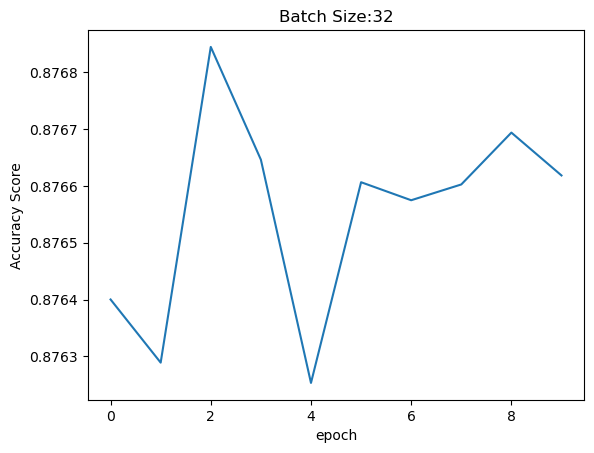

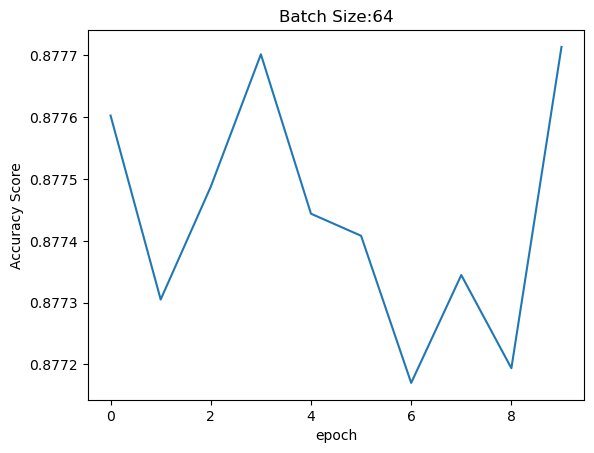

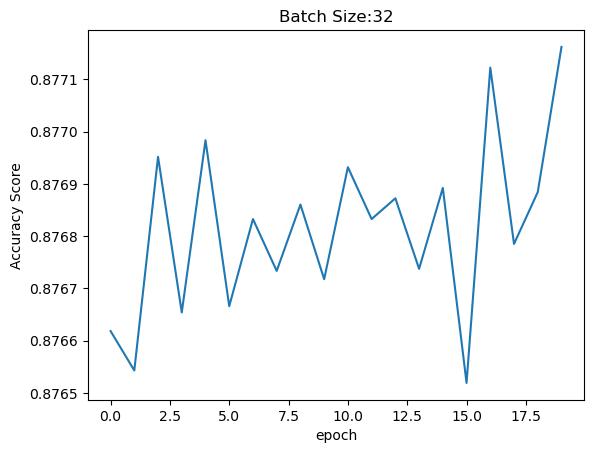

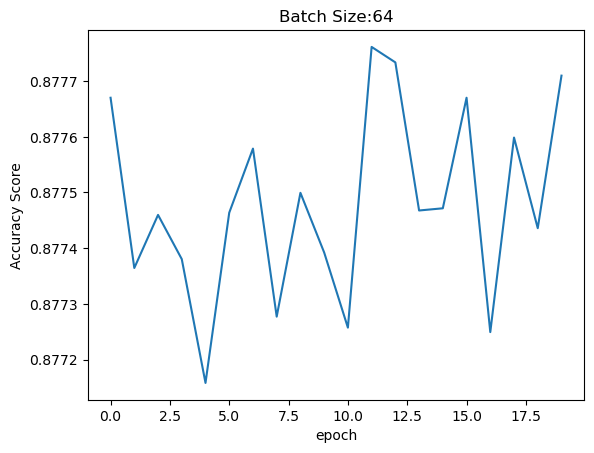

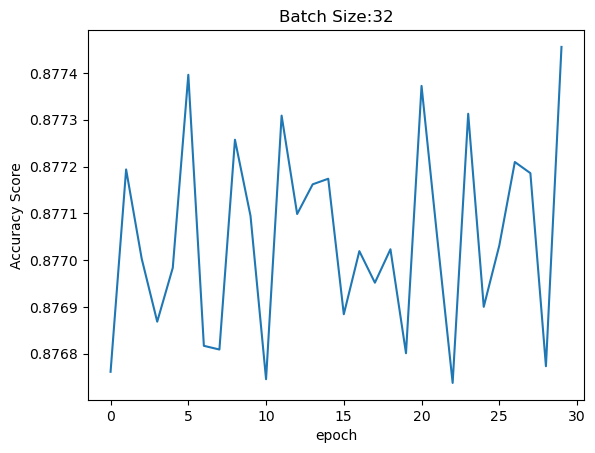

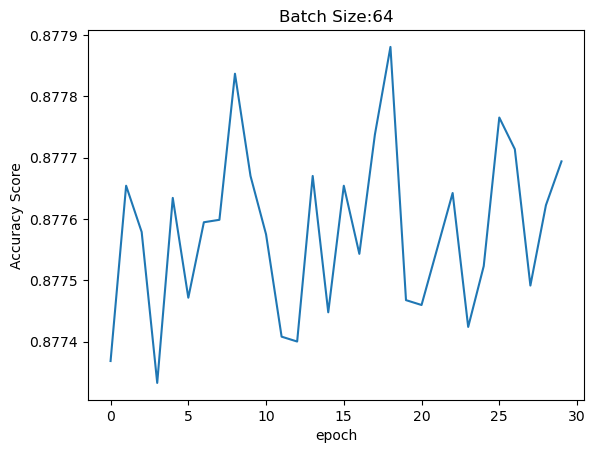

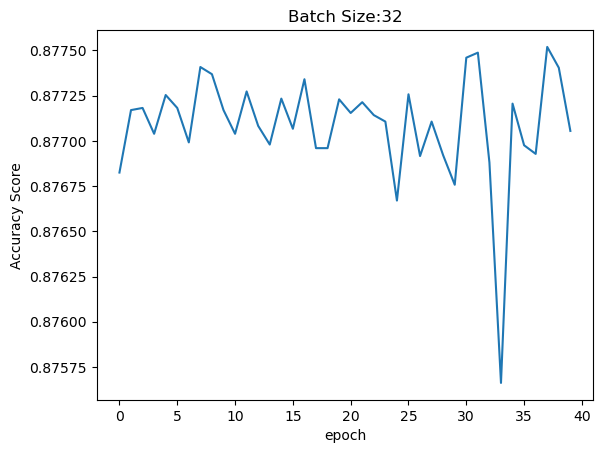

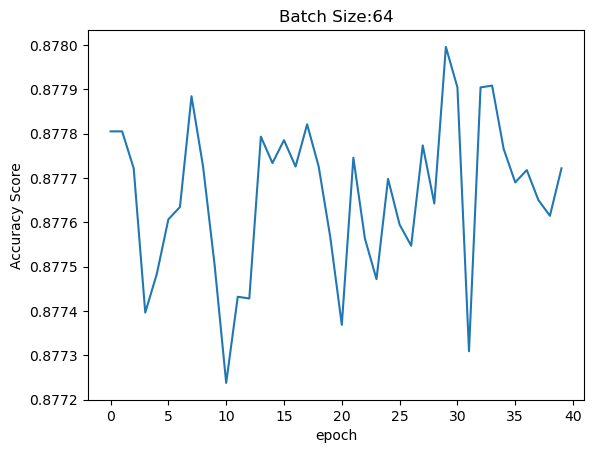

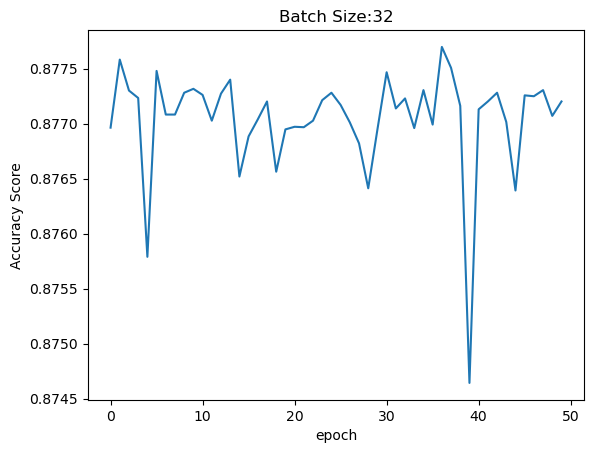

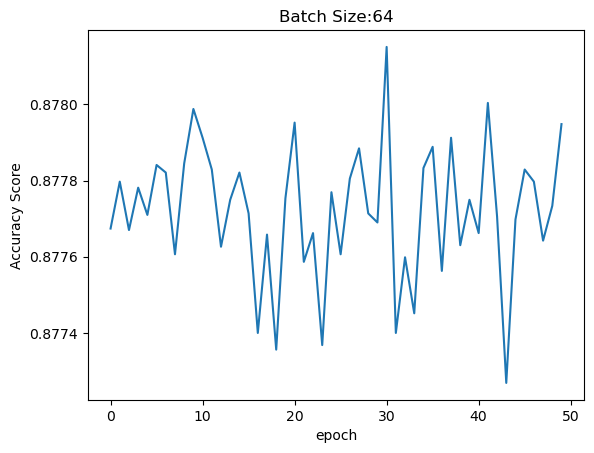

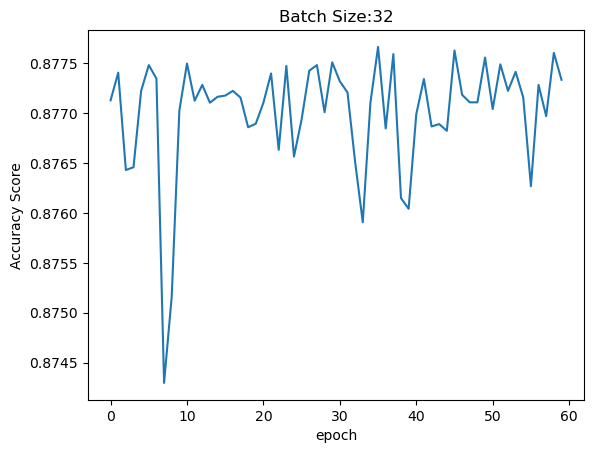

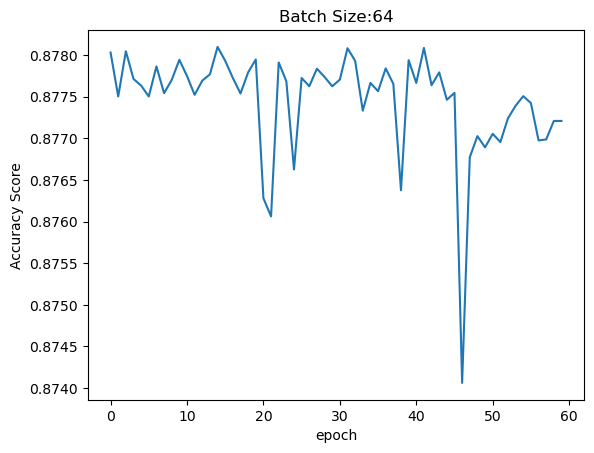

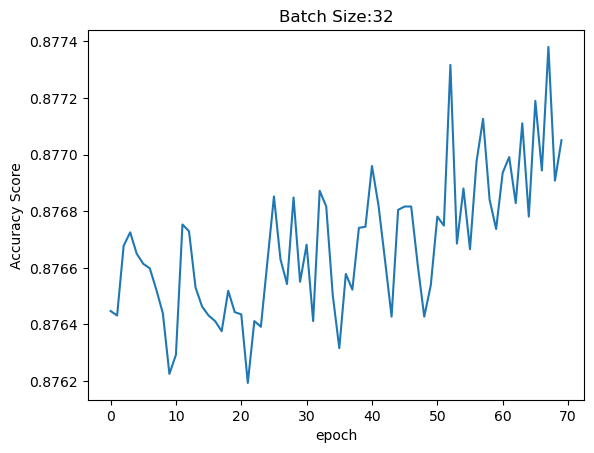

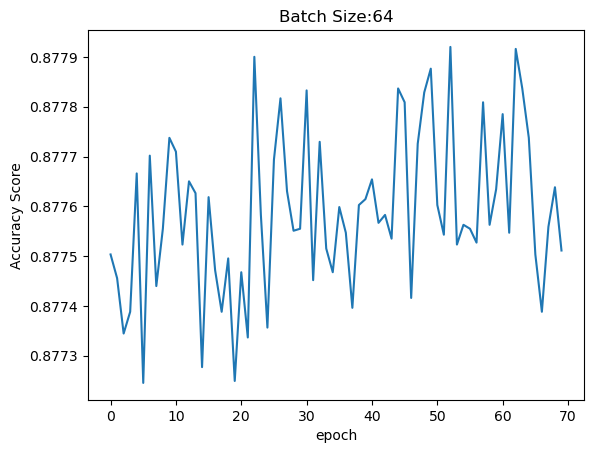

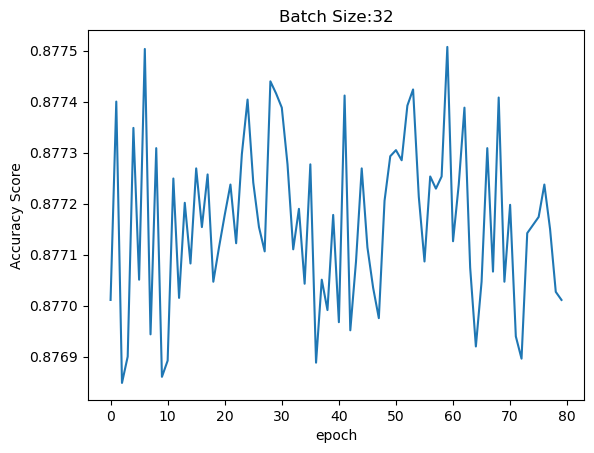

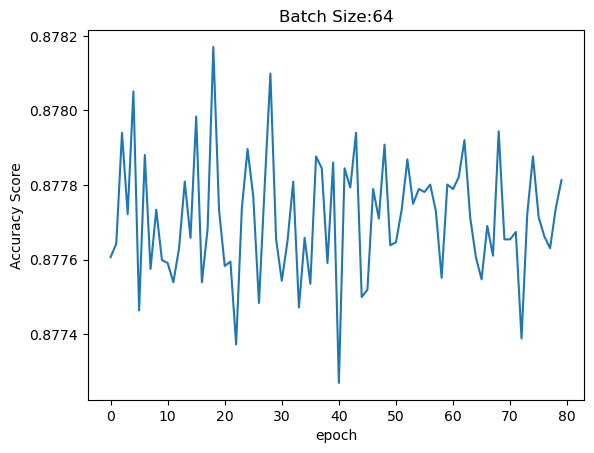

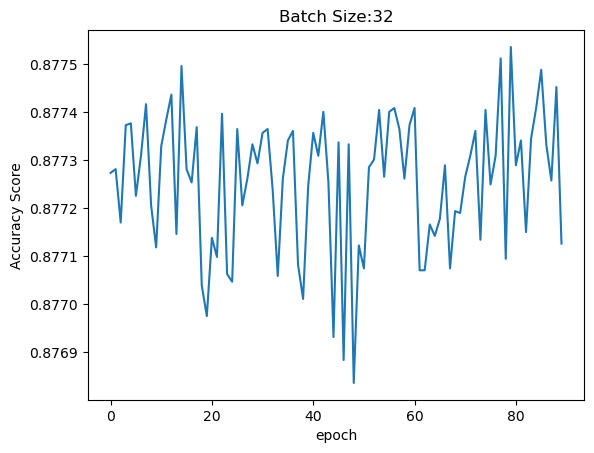

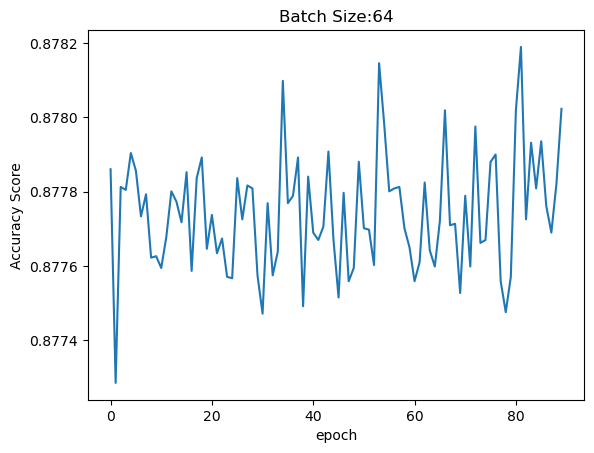

In [52]:
for epoch in range(10,100,10):
    for batch in range(32,96,32):
        
        history = model.fit(x=X_train, y=y_train, batch_size=batch, epochs=epoch, verbose=0)
        plt.plot(range(0,epoch), history.history['accuracy'])
        plt.title('Batch Size:'+ str(batch))
        plt.xlabel("epoch")
        plt.ylabel("Accuracy Score")
        plt.show()

#### The best accuracy score was 0.8782 with 82 epochs and batch size = 64

In [54]:
history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=82, verbose=1)

Epoch 1/82
3937/3937 [==============================] - 4s 906us/step - loss: 0.3313 - accuracy: 0.8776
Epoch 2/82
3937/3937 [==============================] - 4s 904us/step - loss: 0.3312 - accuracy: 0.8780
Epoch 3/82
3937/3937 [==============================] - 4s 920us/step - loss: 0.3314 - accuracy: 0.8777
Epoch 4/82
3937/3937 [==============================] - 4s 904us/step - loss: 0.3312 - accuracy: 0.8780
Epoch 5/82
3937/3937 [==============================] - 4s 917us/step - loss: 0.3314 - accuracy: 0.8779
Epoch 6/82
3937/3937 [==============================] - 4s 912us/step - loss: 0.3312 - accuracy: 0.8780
Epoch 7/82
3937/3937 [==============================] - 4s 911us/step - loss: 0.3314 - accuracy: 0.8778
Epoch 8/82
3937/3937 [==============================] - 4s 929us/step - loss: 0.3313 - accuracy: 0.8776
Epoch 9/82
3937/3937 [==============================] - 4s 922us/step - loss: 0.3313 - accuracy: 0.8778
Epoch 10/82
3937/3937 [==============================] - 4s 921u

In [55]:
predictions = model.predict(x=X_valid, batch_size=64, verbose=0)  

In [56]:
rounded_predictions = np.argmax(predictions, axis=-1)

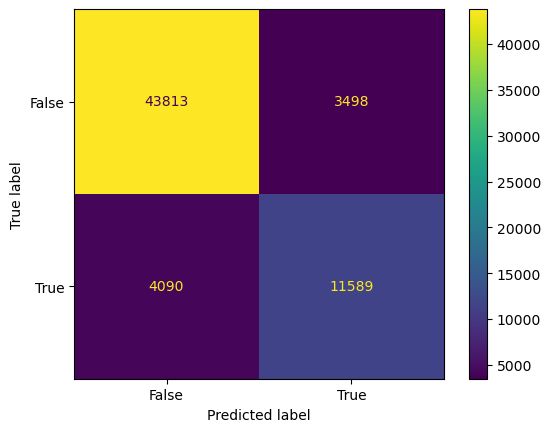

In [57]:
actual = y_valid.copy()
preds = rounded_predictions.copy()

confusion_matrix = metrics.confusion_matrix(actual, preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

#### For your convenience I added the option to load the very same model

In [59]:
#from tensorflow.keras.models import load_model
#model.save('NI_Keras_model.h5')
#model = load_model('NI_Keras_model.h5')

#### The confusion matrix reveals the score. after ~88% accuracy score during the training period- Iv'e assigned part of the dataset for validation, but used it for prediction purposes. The model predicted accurately 55,402 values out of 62990  (92.35%)

In [66]:
nn_accuracy = 55402/62990

## Machine Learning
### Random Forest Classifier
#### For the second model tryout I decided to use sklearn random forest classifier, for it's well known high accuracy in classification problems, and not much assumptions and requirements from the dataset (ockham razor principle)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# find the optimal value for num of estimators
scores = []
for n in range(10, 50):
    rand_forest = RandomForestClassifier(n_estimators=n)
    rand_forest.fit(X_train, y_train)
    rand_forest_preds = rand_forest.predict(X_valid)
    scores.append(accuracy_score(y_valid, rand_forest_preds))



Text(0, 0.5, 'Accuracy Score')

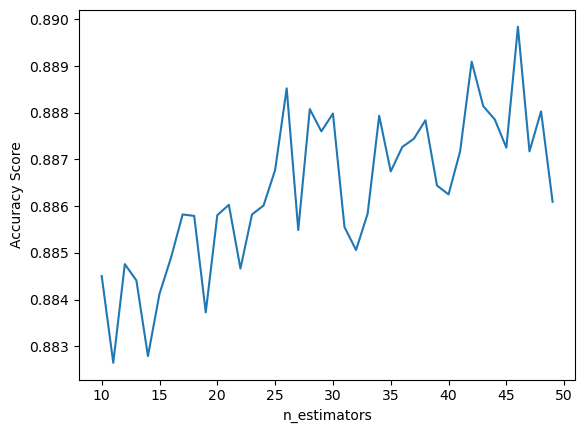

In [26]:
plt.plot(range(10,50),scores)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy Score")

In [27]:
best_n_index = np.argmax(scores)
best_n = list(range(10, 50))[best_n_index]

#### The step above  took about 3 minutes, but was essential. the graph reveals high accuracy score (higher by almost 3% than the keras model) when we use 14 estimators (decision trees) for this problem.

In [28]:
rand_forest = RandomForestClassifier(n_estimators = best_n)
rand_forest.fit(X_train, y_train)
preds = rand_forest.predict(X_valid)

In [29]:
rand_forest_accuracy = accuracy_score(y_valid, preds)

In [30]:
rand_forest_accuracy

0.8873948245753294

In [62]:
#joblib.dump(rand_forest, ".\\random_forest.joblib")
#rand_forest = joblib.load(".\\random_forest.joblib")

['C:\\Users\\User\\Desktop\\NI_Home_Assignment\\models\\random_forest.joblib']

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict(X_valid)
lr_accuracy = [accuracy_score(y_valid, logreg_preds)]

In [32]:
lr_accuracy

[0.8691220828702969]

In [64]:
#joblib.dump(logreg, ".\\logistic_reg.joblib")
#logreg = joblib.load(".\\logistic_reg.joblib")

['C:\\Users\\User\\Desktop\\NI_Home_Assignment\\models\\logistic_reg.joblib']

## K Nearest Neighbor

Text(0, 0.5, 'Predictions accuracy')

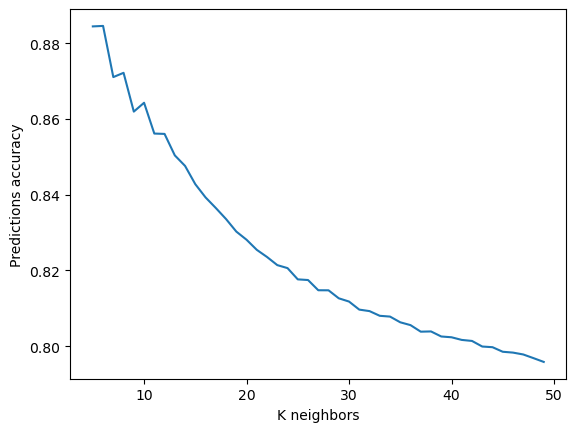

In [44]:
from sklearn.neighbors import KNeighborsClassifier

scores = []
for k in range(5, 50):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_preds = knn.predict(X_valid)
    scores.append(accuracy_score(y_valid, knn_preds))

best_k_index = np.argmax(scores)
best_k = list(range(5, 50))[best_k_index]

plt.plot(range(5, 50), scores)
plt.xlabel('K neighbors')
plt.ylabel('Predictions accuracy')

In [46]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_valid)
knn_accuracy = accuracy_score(y_valid, knn_preds)

In [47]:
knn_accuracy

0.8845531036672488

In [65]:
#joblib.dump(knn, ".\\knn.joblib")
#knn = joblib.load(".\\knn.joblib")

['C:\\Users\\User\\Desktop\\NI_Home_Assignment\\models\\knn.joblib']

# Best Model Performence Analysis

C:\Users\User\anaconda3\envs\py3\lib\site-packages\numpy\lib\stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
C:\Users\User\anaconda3\envs\py3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


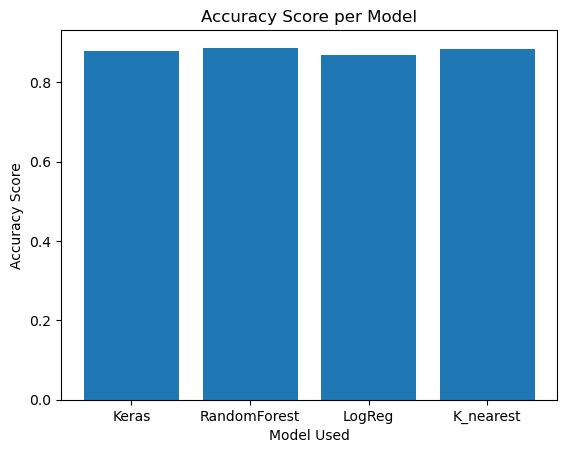

In [71]:
comparison_components = {'Keras':nn_accuracy, 'RandomForest':rand_forest_accuracy, 'LogReg':lr_accuracy,
                         'K_nearest':knn_accuracy}
accuracy = list(comparison_components.values())
heads = list(comparison_components.keys())

plt.bar(heads, height = accuracy)
plt.xlabel("Model Used")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score per Model")
plt.show()

#### The Random Forest model outperform the others (after a close competition) and hence we'll use it for predicting our actual test set 

# Predictions on the test set with the best model

In [72]:
test_data = pd.read_csv('C:\\Users\\User\\Desktop\\home_assignment_data\\df_wafers_test.csv').copy()

#### Checking if there are mutual wafers between the train and test data, because we dont want to confuse the model with the ordinal encoding values

In [74]:
test_wafername_lst = test_data.WaferName.unique()
mutual_wafers = []
for wafer in test_wafername_lst:
    if wafer in wafer_name_lst:
        mutual_wafers.append(wafer)

mutual_wafers        

[]

#### Got an empty list, hence there are no mutual values

#### Is_Low_Yeild check on the test data

In [75]:
low_yeild_wafers = Is_Low_Yeild(test_data, test_wafername_lst)

In [76]:
low_yeild_wafers

[]

#### Got an empty list, hence there are no low yeild wafers in the test set as well

In [77]:
test_data['WaferName'] = ordinal_encoder.fit_transform(test_data[['WaferName']])
test_data.IsGoodDie = test_data.IsGoodDie.astype(int)

test_data

,WaferName,DieX,DieY,IsGoodDie
0,160.0,0,12,0
1,160.0,0,13,1
2,160.0,0,14,1
3,160.0,0,15,1
4,160.0,0,16,1
...,...,...,...,...
1860058,352.0,20,10,1
1860059,352.0,20,11,1
1860060,352.0,20,12,1
1860061,352.0,20,13,1


In [78]:
test_preds = rand_forest.predict(test_data)

In [79]:
test_preds_df = pd.DataFrame(test_preds, columns=['Predictions'])

In [80]:
test_preds_df.to_csv('C:\\Users\\User\\Desktop\\NI_Home_Assignment\\test_predictions.csv')